In [20]:
import numpy as np
import pickle as pkl
import time
import json
import random
import torch
from torch import nn
import editdistance
import os
import matplotlib.pyplot as plt
np.seterr(divide='ignore') # masks log(0) errors

{'divide': 'ignore', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [21]:
from hmm.multiple import FullGaussianHMM
from hmm.single import GaussianHMM

In [11]:
"""
Single Digit HMM
"""
data_single_digit = np.load("hmm/data/mfccs_single.npz")

n_states = 25
n_dims = 13
n_iter = 5
model = dict()
digits = range(10)
    
for digit in digits:
    print("Training HMM for digit %d" % digit)
    Xtrain_digit = [x for x, y in zip(data_single_digit["Xtrain"], data_single_digit["Ytrain"]) if y == digit]
    model[digit] = GaussianHMM(n_states=n_states, n_dims=n_dims)
    model[digit].init_gaussian_params(Xtrain_digit)
    model[digit].init_hmm_params()
    for i in range(n_iter):
        print("starting iteration {}...".format(i+1))
        model[digit].train(Xtrain_digit)

print("Testing HMM")
accuracy = np.zeros(10)
confusion = np.zeros((10, 10))
for x, y in zip(data_single_digit["Xtest"], data_single_digit["Ytest"]):
    T = len(x)

    scores = []
    for digit in digits:
        log_pi = np.log(model[digit].pi)
        log_A = np.log(model[digit].A)
        log_B = model[digit].get_emissions(x)
        _, log_prob = model[digit].viterbi(log_pi, log_A, log_B)
        scores.append(log_prob)

    top_digit, top_log_prob = sorted(zip(digits, scores), key=lambda x: -x[1])[0]
    confusion[y, top_digit] += 1.

accuracy = np.diag(confusion) / confusion.sum(axis=1)

print("accuracy ({:.4f}): {}".format(accuracy.mean(), accuracy))

with open("hmm/single_digit_model.pkl", "wb") as f:
    pkl.dump(model, f)

Training HMM for digit 0
starting iteration 1...
starting iteration 2...
starting iteration 3...
starting iteration 4...
starting iteration 5...
Training HMM for digit 1
starting iteration 1...
starting iteration 2...
starting iteration 3...
starting iteration 4...
starting iteration 5...
Training HMM for digit 2
starting iteration 1...
starting iteration 2...
starting iteration 3...
starting iteration 4...
starting iteration 5...
Training HMM for digit 3
starting iteration 1...
starting iteration 2...
starting iteration 3...
starting iteration 4...
starting iteration 5...
Training HMM for digit 4
starting iteration 1...
starting iteration 2...
starting iteration 3...
starting iteration 4...
starting iteration 5...
Training HMM for digit 5
starting iteration 1...
starting iteration 2...
starting iteration 3...
starting iteration 4...
starting iteration 5...
Training HMM for digit 6
starting iteration 1...
starting iteration 2...
starting iteration 3...
starting iteration 4...
starting 

In [12]:
"""
Multiple Digit HMM
"""
data_multiple_digit = np.load("hmm/data/mfccs_multiple.npz")
full_model = FullGaussianHMM(data_multiple_digit["Xtrain"], "hmm/single_digit_model.pkl")

n_iter = 5

print("Training HMM")
for i in range(n_iter):
    print("starting iteration {}...".format(i + 1))
    full_model.train(data_multiple_digit["Xtrain"], data_multiple_digit["Ytrain"])

print("Testing HMM")
test_wer = full_model.test(data_multiple_digit["Xtest"], data_multiple_digit["Ytest"])
print("{:.2f}% WER".format(test_wer * 100.))

Training HMM
starting iteration 1...
50 examples...
100 examples...
150 examples...
200 examples...
250 examples...
300 examples...
350 examples...
400 examples...
450 examples...
500 examples...
starting iteration 2...
50 examples...
100 examples...
150 examples...
200 examples...
250 examples...
300 examples...
350 examples...
400 examples...
450 examples...
500 examples...
starting iteration 3...
50 examples...
100 examples...
150 examples...
200 examples...
250 examples...
300 examples...
350 examples...
400 examples...
450 examples...
500 examples...
starting iteration 4...
50 examples...
100 examples...
150 examples...
200 examples...
250 examples...
300 examples...
350 examples...
400 examples...
450 examples...
500 examples...
starting iteration 5...
50 examples...
100 examples...
150 examples...
200 examples...
250 examples...
300 examples...
350 examples...
400 examples...
450 examples...
500 examples...
Testing HMM
17.65% WER


In [4]:
from rnn.loader import make_loader, Preprocessor
from rnn.model import Seq2Seq
from rnn.model import LinearND #Hint: this is useful when defining the modified attention mechanism

In [5]:
class Attention(nn.Module):
    def __init__(self, enc_dim, dec_dim, attn_dim=None):
        """
        Initialize Attention.
        ----
        enc_dim: encoder hidden state dimension
        dec_dim: decoder hidden state dimension
        attn_dim: attention feature dimension
        """
        super(Attention, self).__init__()
        if enc_dim == dec_dim and attn_dim is None:
            self.use_default = True
        elif attn_dim is not None:
            self.use_default = False
            self.attn_dim = attn_dim
            self.enc_dim = enc_dim
            self.dec_dim = dec_dim
            self.v = LinearND(self.attn_dim, 1, bias=False)
            self.W1 = LinearND(self.enc_dim, self.attn_dim, bias=False)
            self.W2 = nn.Linear(self.dec_dim, self.attn_dim, bias=False)
        else:
            raise ValueError("invalid args (enc_dim={}, dec_dim={}, attn_dim={})".format(enc_dim, dec_dim, attn_dim))

    def forward(self, eh, dhx, ax=None):
        """
        Forward Attention method.
        ----
        eh (FloatTensor): the encoder hidden state with
            shape (batch size, time, hidden dimension).
        dhx (FloatTensor): one time step of the decoder hidden
            state with shape (batch size, hidden dimension).
        ax (FloatTensor): one time step of the attention vector.
        ----
        Returns the context vectors (sx) and the corresponding attention alignment (ax)
        """
        
        if self.use_default:
            # Compute inner product of decoder slice with every encoder slice
            pax = torch.sum(eh * dhx, dim=2)
            ax = nn.functional.softmax(pax, dim=1)
            sx = torch.sum(eh * ax.unsqueeze(2), dim=1, keepdim=True)
        else:
            pax = self.v(nn.functional.tanh((self.W1(eh)+self.W2(dhx))))
            ax = nn.functional.softmax(pax, dim=1)
            sx = torch.sum(eh * ax, dim=1, keepdim=True)
        return sx, ax

In [28]:
def compute_wer(results):
    """
    Compute the word-error-rate (WER).
    """
    dist = 0.
    for label, pred in results:
        dist += editdistance.eval(label, pred)
    total = sum(len(label) for label, _ in results)
    return dist / total

def train(model, optimizer, ldr):
    """
    Train the model for an epoch (one pass over the training data)
    ----
    model: Seq2Seq model instance
    optimizer: torch.nn optimizer instance
    ldr: data loader instance
    ----
    Returns the average loss over an epoch
    """
    model.train()
    model.scheduled_sampling = model.sample_prob != 0
    
    losses = []
    
    for ii, (inputs, labels) in enumerate(ldr):
        optimizer.zero_grad()
        x, y = model.collate(inputs, labels)
        loss = model.loss(x, y)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        losses.append(loss.data.item())
        
    return np.mean(losses)

def evaluate(model, ldr, preproc):
    """
    Evaluate the model (on either dev or test).
    ----
    model: Seq2Seq model instance
    ldr: data loader instance
    preproc: preprocessor instance
    ----
    Returns the average loss and wer on a given dataset
    """
    model.eval()
    model.scheduled_sampling = False
    
    losses, hyps, refs = [], [], []
    
    with torch.no_grad():
        for inputs, labels in ldr:
            x, y = model.collate(inputs, labels)
            # get loss
            loss = model.loss(x, y)
            losses.append(loss.data.item())
            # get predictions
            pred = model.infer(x, y)
            hyps.extend(pred)
            refs.extend(labels)

    results = [(preproc.decode(r), preproc.decode(h)) for r, h in zip(refs, hyps)]
    
    return np.mean(losses), compute_wer(results)

In [29]:
"""
Use the development set to tune your model.
------
With the default config, can get <10% dev WER within 15 epochs.
"""

with open("rnn/config.json", "r") as fid:                                                                                                                                                                                                                                      
    config = json.load(fid)

random.seed(config["seed"])
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])

use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.backends.cudnn.deterministic = True

print("Training RNN")
data_cfg = config["data"]
model_cfg = config["model"]
opt_cfg = config["optimizer"]

preproc = Preprocessor(data_cfg["train_set"], start_and_end=data_cfg["start_and_end"])

train_ldr = make_loader(data_cfg["train_set"], preproc, opt_cfg["batch_size"])
dev_ldr = make_loader(data_cfg["dev_set"], preproc, opt_cfg["batch_size"])

attention = Attention(model_cfg["encoder"]["hidden_size"], model_cfg["decoder"]["hidden_size"], 16)
model = Seq2Seq(preproc.input_dim, preproc.vocab_size, attention, model_cfg)
model = model.cuda() if use_cuda else model.cpu()

optimizer = torch.optim.SGD(model.parameters(), lr=opt_cfg["learning_rate"], momentum=opt_cfg["momentum"])

log="epoch {:4} | train_loss={:6.2f}, dev_loss={:6.2f} with {:6.2f}% WER ({:6.2f}s elapsed)"

best_so_far = float("inf")
for ep in range(opt_cfg["max_epochs"]):
    start = time.time()
    
    train_loss = train(model, optimizer, train_ldr)    
    dev_loss, dev_wer = evaluate(model, dev_ldr, preproc)
    
    print(log.format(ep + 1, train_loss, dev_loss, dev_wer * 100., time.time() - start))
    
    torch.save(model, os.path.join(config["save_path"], str(ep)))
    
    if dev_wer < best_so_far:
        best_so_far = dev_wer
        torch.save(model, os.path.join(config["save_path"], "best"))

Training RNN
epoch    1 | train_loss=  5.32, dev_loss=  4.37 with  78.04% WER (  7.16s elapsed)


/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch    2 | train_loss=  4.01, dev_loss=  3.72 with  70.36% WER (  6.56s elapsed)
epoch    3 | train_loss=  3.42, dev_loss=  3.15 with  60.54% WER (  6.51s elapsed)
epoch    4 | train_loss=  2.97, dev_loss=  2.87 with  50.89% WER (  6.29s elapsed)
epoch    5 | train_loss=  2.64, dev_loss=  2.90 with  53.57% WER (  6.31s elapsed)
epoch    6 | train_loss=  2.50, dev_loss=  2.56 with  48.04% WER (  7.56s elapsed)
epoch    7 | train_loss=  2.34, dev_loss=  2.77 with  53.21% WER (  5.96s elapsed)
epoch    8 | train_loss=  2.14, dev_loss=  2.47 with  44.82% WER (  6.67s elapsed)
epoch    9 | train_loss=  2.24, dev_loss=  2.39 with  46.43% WER (  6.03s elapsed)
epoch   10 | train_loss=  2.09, dev_loss=  2.42 with  44.64% WER (  6.46s elapsed)
epoch   11 | train_loss=  1.91, dev_loss=  1.98 with  38.04% WER (  5.80s elapsed)
epoch   12 | train_loss=  1.67, dev_loss=  2.25 with  37.86% WER (  5.72s elapsed)
epoch   13 | train_loss=  1.60, dev_loss=  1.52 with  22.50% WER (  5.77s elapsed)
epoc

In [30]:
"""
Use the development set to tune your model.
------
With the default config, can get <10% dev WER within 15 epochs.
"""

with open("rnn/config.json", "r") as fid:                                                                                                                                                                                                                                      
    config = json.load(fid)

random.seed(config["seed"])
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])

use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.backends.cudnn.deterministic = True

print("Training RNN")
data_cfg = config["data"]
model_cfg = config["model"]
opt_cfg = config["optimizer"]

preproc = Preprocessor(data_cfg["train_set"], start_and_end=data_cfg["start_and_end"])

train_ldr = make_loader(data_cfg["train_set"], preproc, opt_cfg["batch_size"])
dev_ldr = make_loader(data_cfg["dev_set"], preproc, opt_cfg["batch_size"])

attention = Attention(model_cfg["encoder"]["hidden_size"], model_cfg["decoder"]["hidden_size"])
model = Seq2Seq(preproc.input_dim, preproc.vocab_size, attention, model_cfg)
model = model.cuda() if use_cuda else model.cpu()

global total_time
total_time = []
global train_loss_vector
train_loss_vector = []
global dev_loss_vector
dev_loss_vector = []
global wer_vector
wer_vector = []

optimizer = torch.optim.SGD(model.parameters(), lr=opt_cfg["learning_rate"], momentum=opt_cfg["momentum"])

log="epoch {:4} | train_loss={:6.2f}, dev_loss={:6.2f} with {:6.2f}% WER ({:6.2f}s elapsed)"

best_so_far = float("inf")
for ep in range(opt_cfg["max_epochs"]):
    start = time.time()
    
    train_loss = train(model, optimizer, train_ldr)    
    dev_loss, dev_wer = evaluate(model, dev_ldr, preproc)
    
    print(log.format(ep + 1, train_loss, dev_loss, dev_wer * 100., time.time() - start))
    if ep == 0:
        total_time.append(time.time() - start)
    else:
        total_time.append(time.time()-start+total_time[ep-1])
    train_loss_vector.append(train_loss)
    dev_loss_vector.append(dev_loss)
    wer_vector.append(dev_wer)
    torch.save(model, os.path.join(config["save_path"], str(ep)))
    
    if dev_wer < best_so_far:
        best_so_far = dev_wer
        torch.save(model, os.path.join(config["save_path"], "best"))
print(total_time)
print(train_loss_vector)
print(dev_loss_vector)
print(wer_vector)

Training RNN
epoch    1 | train_loss=  5.49, dev_loss=  4.82 with  76.43% WER (  5.02s elapsed)


/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch    2 | train_loss=  4.01, dev_loss=  3.68 with  63.93% WER (  5.05s elapsed)
epoch    3 | train_loss=  3.44, dev_loss=  3.30 with  60.18% WER (  5.09s elapsed)
epoch    4 | train_loss=  2.99, dev_loss=  2.99 with  50.89% WER (  5.04s elapsed)
epoch    5 | train_loss=  2.35, dev_loss=  3.53 with  59.29% WER (  5.07s elapsed)
epoch    6 | train_loss=  2.36, dev_loss=  1.92 with  34.64% WER (  5.05s elapsed)
epoch    7 | train_loss=  1.45, dev_loss=  1.29 with  21.79% WER (  5.07s elapsed)
epoch    8 | train_loss=  1.15, dev_loss=  1.02 with  15.36% WER (  5.18s elapsed)
epoch    9 | train_loss=  1.29, dev_loss=  1.22 with  19.29% WER (  5.03s elapsed)
epoch   10 | train_loss=  0.87, dev_loss=  1.32 with  20.71% WER (  5.05s elapsed)
epoch   11 | train_loss=  0.87, dev_loss=  1.07 with  17.32% WER (  5.12s elapsed)
epoch   12 | train_loss=  0.59, dev_loss=  1.03 with  16.25% WER (  5.02s elapsed)
epoch   13 | train_loss=  0.45, dev_loss=  0.79 with  11.96% WER (  5.21s elapsed)
epoc

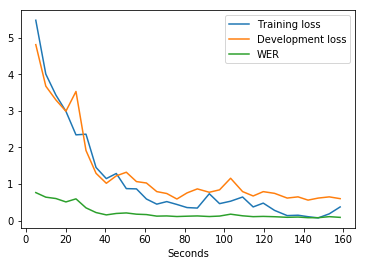

In [31]:
plt.plot(total_time, train_loss_vector, label = 'Training loss')
plt.plot(total_time, dev_loss_vector, label = 'Development loss')
plt.plot(total_time, wer_vector, label = 'WER')
plt.xlabel('Seconds')
plt.legend()
plt.show()

In [34]:
"""
Use the development set to tune your model.
------
With the default config, can get <10% dev WER within 15 epochs.
"""

with open("rnn/config.json", "r") as fid:                                                                                                                                                                                                                                      
    config = json.load(fid)

random.seed(config["seed"])
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])

use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.backends.cudnn.deterministic = True

print("Training RNN")
data_cfg = config["data"]
model_cfg = config["model"]
opt_cfg = config["optimizer"]

preproc = Preprocessor(data_cfg["train_set"], start_and_end=data_cfg["start_and_end"])

train_ldr = make_loader(data_cfg["train_set"], preproc, opt_cfg["batch_size"])
dev_ldr = make_loader(data_cfg["dev_set"], preproc, opt_cfg["batch_size"])

attention = Attention(model_cfg["encoder"]["hidden_size"], model_cfg["decoder"]["hidden_size"], 16)
model = Seq2Seq(preproc.input_dim, preproc.vocab_size, attention, model_cfg)
model = model.cuda() if use_cuda else model.cpu()

optimizer = torch.optim.SGD(model.parameters(), lr=opt_cfg["learning_rate"], momentum=opt_cfg["momentum"])

log="epoch {:4} | train_loss={:6.2f}, dev_loss={:6.2f} with {:6.2f}% WER ({:6.2f}s elapsed)"

best_so_far = float("inf")
for ep in range(opt_cfg["max_epochs"]):
    start = time.time()
    
    train_loss = train(model, optimizer, train_ldr)    
    dev_loss, dev_wer = evaluate(model, dev_ldr, preproc)
    
    print(log.format(ep + 1, train_loss, dev_loss, dev_wer * 100., time.time() - start))
    
    torch.save(model, os.path.join(config["save_path"], str(ep)))
    
    if dev_wer < best_so_far:
        best_so_far = dev_wer
        torch.save(model, os.path.join(config["save_path"], "best"))

Training RNN
epoch    1 | train_loss=  5.39, dev_loss=  5.02 with  86.61% WER (  5.52s elapsed)


/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch    2 | train_loss=  4.11, dev_loss=  3.71 with  69.46% WER (  5.63s elapsed)
epoch    3 | train_loss=  3.46, dev_loss=  3.71 with  66.79% WER (  5.68s elapsed)
epoch    4 | train_loss=  3.13, dev_loss=  3.17 with  55.00% WER (  5.57s elapsed)
epoch    5 | train_loss=  3.00, dev_loss=  3.50 with  60.71% WER (  5.56s elapsed)
epoch    6 | train_loss=  2.55, dev_loss=  2.53 with  46.96% WER (  5.55s elapsed)
epoch    7 | train_loss=  2.43, dev_loss=  2.87 with  52.68% WER (  5.63s elapsed)
epoch    8 | train_loss=  2.24, dev_loss=  2.48 with  46.61% WER (  5.57s elapsed)
epoch    9 | train_loss=  2.21, dev_loss=  2.41 with  46.07% WER (  5.57s elapsed)
epoch   10 | train_loss=  2.05, dev_loss=  2.34 with  44.29% WER (  5.54s elapsed)
epoch   11 | train_loss=  2.06, dev_loss=  2.20 with  43.21% WER (  5.58s elapsed)
epoch   12 | train_loss=  1.86, dev_loss=  2.24 with  40.18% WER (  5.55s elapsed)
epoch   13 | train_loss=  1.81, dev_loss=  2.09 with  38.21% WER (  5.66s elapsed)
epoc

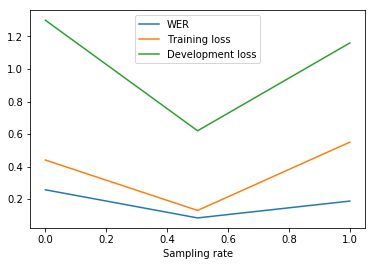

In [35]:
Sampling_rate = [0, 0.5, 1]
WER_sampling_rate = [0.257, 0.084, 0.1875]
Training_loss_sampling = [0.44, 0.13, 0.55]
Dev_loss_sampling = [1.3, 0.62, 1.16]
plt.plot(Sampling_rate,WER_sampling_rate, label = 'WER')
plt.plot(Sampling_rate, Training_loss_sampling, label = 'Training loss')
plt.plot(Sampling_rate, Dev_loss_sampling, label = 'Development loss')
plt.xlabel('Sampling rate')
plt.legend()
plt.show()

In [40]:
"""
Use the development set to tune your model.
------
With the default config, can get <10% dev WER within 15 epochs.
"""

with open("rnn/config.json", "r") as fid:                                                                                                                                                                                                                                      
    config = json.load(fid)

random.seed(config["seed"])
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])

use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.backends.cudnn.deterministic = True

print("Training RNN")
data_cfg = config["data"]
model_cfg = config["model"]
opt_cfg = config["optimizer"]

preproc = Preprocessor(data_cfg["train_set"], start_and_end=data_cfg["start_and_end"])

train_ldr = make_loader(data_cfg["train_set"], preproc, opt_cfg["batch_size"])
dev_ldr = make_loader(data_cfg["dev_set"], preproc, opt_cfg["batch_size"])

attention = Attention(model_cfg["encoder"]["hidden_size"], model_cfg["decoder"]["hidden_size"], 6)
model = Seq2Seq(preproc.input_dim, preproc.vocab_size, attention, model_cfg)
model = model.cuda() if use_cuda else model.cpu()

optimizer = torch.optim.SGD(model.parameters(), lr=opt_cfg["learning_rate"], momentum=opt_cfg["momentum"])

log="epoch {:4} | train_loss={:6.2f}, dev_loss={:6.2f} with {:6.2f}% WER ({:6.2f}s elapsed)"

best_so_far = float("inf")
for ep in range(opt_cfg["max_epochs"]):
    start = time.time()
    
    train_loss = train(model, optimizer, train_ldr)    
    dev_loss, dev_wer = evaluate(model, dev_ldr, preproc)
    
    print(log.format(ep + 1, train_loss, dev_loss, dev_wer * 100., time.time() - start))
    
    torch.save(model, os.path.join(config["save_path"], str(ep)))
    
    if dev_wer < best_so_far:
        best_so_far = dev_wer
        torch.save(model, os.path.join(config["save_path"], "best"))

Training RNN
epoch    1 | train_loss=  5.37, dev_loss=  4.63 with  79.82% WER (  5.73s elapsed)


/anaconda3/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch    2 | train_loss=  4.36, dev_loss=  4.04 with  69.11% WER (  6.30s elapsed)
epoch    3 | train_loss=  3.97, dev_loss=  3.81 with  70.89% WER (  5.65s elapsed)
epoch    4 | train_loss=  3.56, dev_loss=  3.13 with  56.79% WER (  5.97s elapsed)
epoch    5 | train_loss=  3.07, dev_loss=  3.24 with  59.46% WER (  6.06s elapsed)
epoch    6 | train_loss=  2.76, dev_loss=  2.65 with  52.50% WER (  5.53s elapsed)
epoch    7 | train_loss=  2.58, dev_loss=  2.62 with  56.43% WER (  5.45s elapsed)
epoch    8 | train_loss=  2.39, dev_loss=  2.19 with  46.25% WER (  5.44s elapsed)
epoch    9 | train_loss=  2.25, dev_loss=  2.18 with  52.68% WER (  6.32s elapsed)
epoch   10 | train_loss=  2.21, dev_loss=  2.03 with  48.93% WER (  5.43s elapsed)
epoch   11 | train_loss=  2.12, dev_loss=  2.23 with  46.61% WER (  5.41s elapsed)
epoch   12 | train_loss=  2.04, dev_loss=  1.89 with  48.21% WER (  5.39s elapsed)
epoch   13 | train_loss=  1.92, dev_loss=  1.89 with  47.14% WER (  5.38s elapsed)
epoc

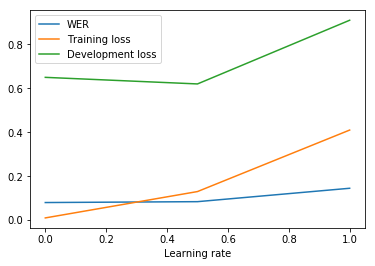

In [39]:
Learning_rate = [0.5, 1, 1.5]
WER_learning_rate = [0.08,0.084, 0.145]
Training_loss_learning = [0.01,0.13, 0.41]
Dev_loss_learning = [0.65, 0.62, 0.91]
plt.plot(Sampling_rate,WER_learning_rate, label = 'WER')
plt.plot(Sampling_rate, Training_loss_learning, label = 'Training loss')
plt.plot(Sampling_rate, Dev_loss_learning, label = 'Development loss')
plt.xlabel('Learning rate')
plt.legend()
plt.show()

In [41]:
print("Testing RNN")
test_model = torch.load(os.path.join(config["save_path"], "best"))
test_ldr = make_loader(data_cfg["test_set"], preproc, opt_cfg["batch_size"])

_, test_wer = evaluate(test_model, test_ldr, preproc)

print("{:.2f}% WER (test)".format(test_wer * 100.))

Testing RNN
6.19% WER (test)
